In [18]:
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt
import importlib
import functions as func

importlib.reload(func)

import contextlib
import os
from urllib.request import urlretrieve
from scipy.integrate import solve_ivp
from scipy.sparse import linalg
from sympy import *
from scipy.sparse import csr_matrix
from matplotlib.animation import FuncAnimation


#### Breakwater parameters

In [19]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall


#### Mesh definition

In [20]:
gmsh.initialize()
gmsh.model.add("Breakwater")

# Tag offset
tag = 1


# Mesh size
lc_big = 0.8
lc_small = 0.4

p_center = gmsh.model.geo.addPoint(seaside+tip, roof-2*tip, 0, lc_small, tag); tag += 1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc_big, tag); tag += 1
p2 = gmsh.model.geo.addPoint(0, top, 0, lc_big, tag); tag += 1
p3 = gmsh.model.geo.addPoint(wall, top, 0, lc_small, tag); tag += 1
p4 = gmsh.model.geo.addPoint(wall, roof, 0, lc_small, tag); tag += 1
p5 = gmsh.model.geo.addPoint(seaside+tip, roof, 0, lc_small, tag); tag += 1
p6 = gmsh.model.geo.addPoint(seaside+tip, roof-tip, 0, lc_small, tag); tag += 1
p7 = gmsh.model.geo.addPoint(seaside, roof-2*tip, 0, lc_small, tag); tag += 1
p8 = gmsh.model.geo.addPoint(seaside, 0, 0, lc_big, tag); tag += 1

# Outer rectangle lines
l_a = gmsh.model.geo.addLine(p1, p2)
l_b = gmsh.model.geo.addLine(p2, p3)
l_c = gmsh.model.geo.addLine(p3, p4)
l_d = gmsh.model.geo.addLine(p4, p5)
l_e = gmsh.model.geo.addLine(p5, p6)
l_f = gmsh.model.geo.addCircleArc(p6, p_center, p7)
l_g = gmsh.model.geo.addLine(p7, p8)
l_h = gmsh.model.geo.addLine(p8, p1)


# Define surface with a hole
outer_loop = gmsh.model.geo.addCurveLoop([l_a, l_b, l_c, l_d, l_e, l_f, l_g, l_h])
interior = gmsh.model.geo.addPlaneSurface([outer_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [interior], interior_tag)  # 2 corresponds to surface dimension

sea_side_tag = 1  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_f, l_g, l_e], sea_side_tag)  # 1 to the line segment

# # Define physical boundary for the left vertical side (l4)
bottom_side_tag = 2  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_h], bottom_side_tag)  # 1 to the line segment

# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("Breakwater.msh")

#### Mesh plotting & boundary visualization

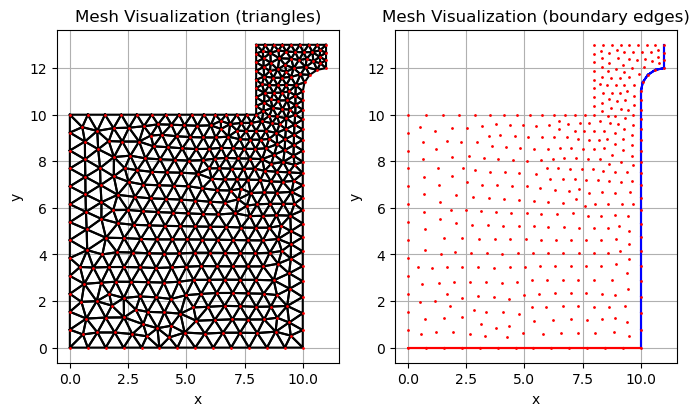

[[ 4 47]
 [47 48]
 [48  5]
 [ 5 49]
 [49 50]
 [50 51]
 [51  6]
 [ 6 52]
 [52 53]
 [53 54]
 [54 55]
 [55 56]
 [56 57]
 [57 58]
 [58 59]
 [59 60]
 [60 61]
 [61 62]
 [62 63]
 [63 64]
 [64 65]
 [65 66]
 [66 67]
 [67 68]
 [68 69]
 [69 70]
 [70  7]]


In [21]:
# Read mesh from file
mesh = meshio.read("Breakwater.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
group_bottom = mesh.get_cell_data("gmsh:physical", "line")
group_sea = mesh.get_cell_data("gmsh:physical", "line")
# edges = mesh.get_cells_type("line") # edges on the left boundary
# edges = mesh.cells_dict.get(2, [])  # edges on the left boundary
bottom_edges = mesh.get_cells_type("line")[group_bottom == bottom_side_tag]
sea_edges = mesh.get_cells_type("line")[group_sea == sea_side_tag]

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in sea_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in bottom_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()

print(sea_edges)


#### Testing gauspoints

In [22]:
qp, weights = func.GaussPoints(points=1)
shape_functions = func.shape_functions(qp)



#### Generating Load

In [23]:
def goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc):
    # beta = wave angle of attack
    # H =  wave height
    # eta = wave height crest elevation
    # hc = crest elevation of the wall (from SWL to top of breakwater or point of interest)
    # labda = wave reflection/transmission coefficients, lecture notes
    # alpha = empirical model coefficients, lecture notes
    # L = wave length
    # l = 
    # hc = 
   
    p1 = 1/2 * (np.cos(beta) + 1) * (alpha1 * labda1 + alpha2 * labda2 *(np.cos(beta)) ** 2) * rho * g * H
    p2 = p1 * (eta - hc) / eta
    p3 = alpha3 * p1
    p3til = 5848 * H * l / (L ** 2) + 9.75
    p2til = 0.45 * p3til
    P1 = p1
    P2 = p2 * (1 + p2til)
    P3 = p3 * (1 + p3til)
    return [P1, P2, P3]

def array_Goda(d, h1, h2, goda):
    # returns array starting from the bottom to the top
    P1 =  goda[0]
    P2 = goda[1]
    P3 = goda[2]
    Pv = []
    # d = SWL
    # h1 = height wrt SWL until curvature
    # h2 = height wrt SWL to highest point
    z = np.linspace(-d, h2, 1000)
    for i in range(len(z)):
        if z[i] < 0:
            P = P1
            Pv.append(P)
        elif z[i]> h1:
            P = (P3 - P2) / (h2 - h1) * (z[i] - h1) + P2
            Pv.append(P)
        else:
            P = (P2 - P1) / (h1) * z[i] + P1
            Pv.append(P)
    return Pv

In [24]:
# examples of input values
beta = 2
alpha1 = 0.05
alpha2 = 1
alpha3 = 0.8
H = 2
labda1 = 4
labda2 = 2
l = roof
L = roof
rho = 1025 # density of salt water
g = 9.81
eta = 1 # time dependent factor
hc = 0.5 # needs to be smaller than eta, otherwise negative P2

d = 10
h1 = 3
h2 = 3.5
# alpha1 = 0.1 * 1/2 * (2 * k * h / (np.sinh(2 * k * h))) ** 2
# #For shallow water: alpha1 = 0, for deep water: alpha = 0.05

# alpha2 = min((hb - d) / (3 * hb) * (Hmax /d) **2, 2 * d / Hmax)


# alpha3 = 1 - h_ / h * (1 - 1/(np.cosh(k * h)))

A = goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc)

goda_dist = array_Goda(d, h1, h2, A)

y_goda = np.linspace(0, roof, 1000)
# plt.plot(array, y)

In [25]:
def find_dz(z_coords):    
    dz_list = np.zeros(len(z_coords))
    z_coords_temp = points[sea_dofs][:, 1]
    while z_coords_temp.shape[0] > 0:
        z_coord = z_coords_temp.min()
        z_coords_temp = np.delete(z_coords_temp, np.where(z_coords_temp == z_coord)[0][0])
        if z_coords_temp.shape[0] > 0:
            z_coord_i = z_coords_temp.min()
        dz = z_coord_i - z_coord
        dz_list[np.where(z_coords == z_coord)] = dz
    return dz_list

def interp_force(z_coords, q, L):
    n = len(q)
    z = np.linspace(0, L, n)
    q_interp = np.interp(z_coords, z, q)

#### Parameters and boundary condtions

In [26]:
# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
k_bottom = -5000000000
density = 2500  # Density in kg/m^3
body_force = np.array([0, -9.81 * density])  # Body force (gravity)
# body_force = np.array([0, 0])  # Body force (gravity)
C = func.elasticity_tensor(E, nu)
Force = 1

# Assemble the global stiffness matrix, mass matrix, and force vector
K, M, f = func.assemble(mesh, triangles, points, C, density, body_force)

# Find the nodes on the foundation (bottom) boundary
bottom_Bnodes = np.where(np.isin(points[:, 1], points[bottom_edges[:, 1], 0]))[0]
bottom_dofs = np.array([[2*n, 2*n+1] for n in bottom_Bnodes]).flatten()

# Find the nodes on the seaside boundary
sea_Bnodes = np.where(np.isin(points[:, 0], points[sea_edges[:, 0], 0]))[0]
sea_Bnodes = [int(x) for x in sea_Bnodes if x not in bottom_Bnodes] # exlcude bottom node(s) from seaside nodes
# sea_dofs = np.array([[2*n, 2*n+1] for n in sea_Bnodes]).flatten()
sea_dofs_x = []
sea_dofs_y = []

for node in sea_Bnodes:
    sea_dofs_x.append(2 * node)  # x-direction dof
    sea_dofs_y.append(2 * node + 1)  # y-direction dof


# Apply the stiffness, mass
for node in bottom_Bnodes:
    dof_x = 2 * node
    dof_y = 2 * node + 1
    K[dof_x, :] = 0  # Set the row to zero
    K[dof_x, dof_x] = 1 # add the bottom stiffness
    M[dof_x, :] = 0  # Set the row to zero
    M[dof_x, dof_x] = 1  # Set the diagonal to 1
    f[dof_x] = 0  # Set the force vector to

    K[dof_y, dof_y] += k_bottom  # Add the bottom stiffness



dz -1.0
dof 8
Force component at dof 8 , at z = 13.0 : -0.0
dof 10
Force component at dof 10 , at z = 12.0 : -38461.538461538505
dof 12
Force component at dof 12 , at z = 11.0 : -76923.07692307691
dof 94
Force component at dof 94 , at z = 12.66666666666667 : -12820.512820512682
dof 96
Force component at dof 96 , at z = 12.33333333333333 : -25641.02564102578
dof 98
Force component at dof 98 , at z = 11.92387953166203 : -41389.24878222967
dof 100
Force component at dof 100 , at z = 11.70710677906724 : -49726.662343567696
dof 102
Force component at dof 102 , at z = 11.38268343133066 : -62204.483410359244
dof 104
Force component at dof 104 , at z = 10.61208575941405 : -91842.85540715192
dof 106
Force component at dof 106 , at z = 10.21049190680447 : -107288.77281521265
dof 108
Force component at dof 108 , at z = 9.794735758190543 : -123279.39391574838
dof 110
Force component at dof 110 , at z = 9.364318074685439 : -139833.9202044062
dof 112
Force component at dof 112 , at z = 8.91872172946

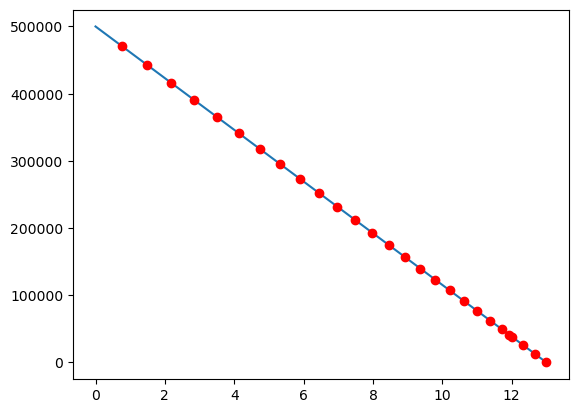

In [56]:
n_fp = 1000
z = y_goda
z = np.linspace(0, roof, n_fp)  # Length of the breakwater
q = np.array(goda_dist)
q = np.linspace(50 * 10e3,0, n_fp) # Force distribution along the length
plt.plot(z, q, label='Force over length')
# print(sea_dofs)
idx_coords = [int(dof / 2) for dof in sea_dofs_x]  # Convert to indices for points

z_coords = points[idx_coords][:, 1]  # Extract z-coordinates of the seaside nodes


q_interp = np.interp(z_coords, z, q)
plt.plot(z_coords, q_interp, 'ro', label='Interpolated Force')
# print("z_coord", z_coords)
# print(sea_dofs)
dz = z_coords[1] - z_coords[0]
print("dz", dz)

for dof in sea_dofs_x:
    print("dof", dof)
    z_coord = points[int(dof / 2), 1] # hier gaat het mis
    i = np.where(z_coords == z_coord)[0]
    q_comp = q_interp[i][0]
    F_comp = q_comp * dz
    f[dof] = F_comp 
    print("Force component at dof", dof,", at z =",z_coord, ":", F_comp)

In [41]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e4


# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-', alpha=0.1)
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-', alpha=0.5)
plt.plot(points[:, 0], points[:, 1], 'bo', markersize=1, alpha =0.1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

Testing Goda

In [29]:
# examples of input values
beta = 2
alpha1 = 0.05
alpha2 = 1
alpha3 = 0.8
H = 2
labda1 = 4
labda2 = 2
l = 15
L = 15
rho = 1025 # density of salt water
g = 9.81
eta = 1 # time dependent factor
hc = 0.5 # needs to be smaller than eta, otherwise negative P2

d = 10
h1 = 3
h2 = 3.5
# alpha1 = 0.1 * 1/2 * (2 * k * h / (np.sinh(2 * k * h))) ** 2
# #For shallow water: alpha1 = 0, for deep water: alpha = 0.05

# alpha2 = min((hb - d) / (3 * hb) * (Hmax /d) **2, 2 * d / Hmax)


# alpha3 = 1 - h_ / h * (1 - 1/(np.cosh(k * h)))

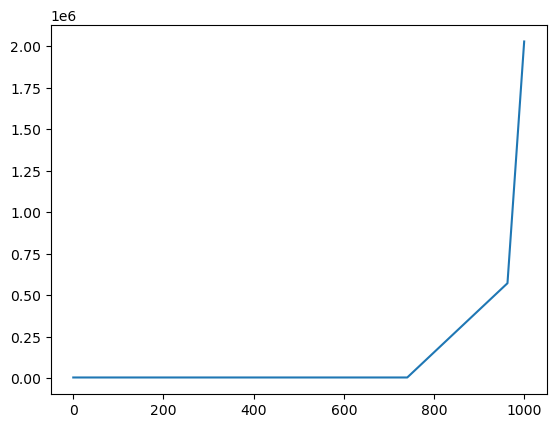

In [30]:
A = goda(beta, alpha1, alpha2, alpha3, labda1, labda2, H, l, L, rho, g, eta, hc)

array = array_Goda(d, h1, h2, A)

x = np.linspace(0, len(array), len(array))
plt.plot(x, array)

#### Central difference method

In [31]:
K = csr_matrix(K)
M = csr_matrix(M)

dt = 0.3 # timestep
T = 20 # total time
time_steps = np.arange(0, T, dt)
beta = 1/4
gamma = 1/2

print(type(f))
print(f.shape)
print(time_steps)

<class 'numpy.ndarray'>
(804,)
[ 0.   0.3  0.6  0.9  1.2  1.5  1.8  2.1  2.4  2.7  3.   3.3  3.6  3.9
  4.2  4.5  4.8  5.1  5.4  5.7  6.   6.3  6.6  6.9  7.2  7.5  7.8  8.1
  8.4  8.7  9.   9.3  9.6  9.9 10.2 10.5 10.8 11.1 11.4 11.7 12.  12.3
 12.6 12.9 13.2 13.5 13.8 14.1 14.4 14.7 15.  15.3 15.6 15.9 16.2 16.5
 16.8 17.1 17.4 17.7 18.  18.3 18.6 18.9 19.2 19.5 19.8]


In [32]:
amplification = 10000

u = np.zeros_like(f)
v = np.zeros_like(f)
a = linalg.spsolve(M, f - K @ u)  # initial acceleration

K_eff = K + M / (beta * dt**2)
K_eff = csr_matrix(K_eff)

u_hist = []

for t in time_steps:
    # Predictor
    u_star = u + dt * v + 0.5 * dt**2 * (1 - 2 * beta) * a
    v_star = v + (1 - gamma) * dt * a

    # External force (could be time-dependent)
    f_ext = f * np.sin(2*np.pi * t) # + other time-dependent forces

    # Effective force
    f_eff = f_ext + M @ (u_star / (beta * dt**2))
    # f_eff = csr_matrix(f_eff)

    # Solve for displacement
    u_new = linalg.spsolve(K_eff, f_eff)
    # Correct acceleration and velocity
    a_new = (u_new - u_star) / (beta * dt**2)
    v_new = v_star + gamma * dt * a_new

    # Update
    u, v, a = u_new, v_new, a_new
    u_resh = u.reshape((-1, 2)) * amplification
    u_hist.append(u_resh.copy())

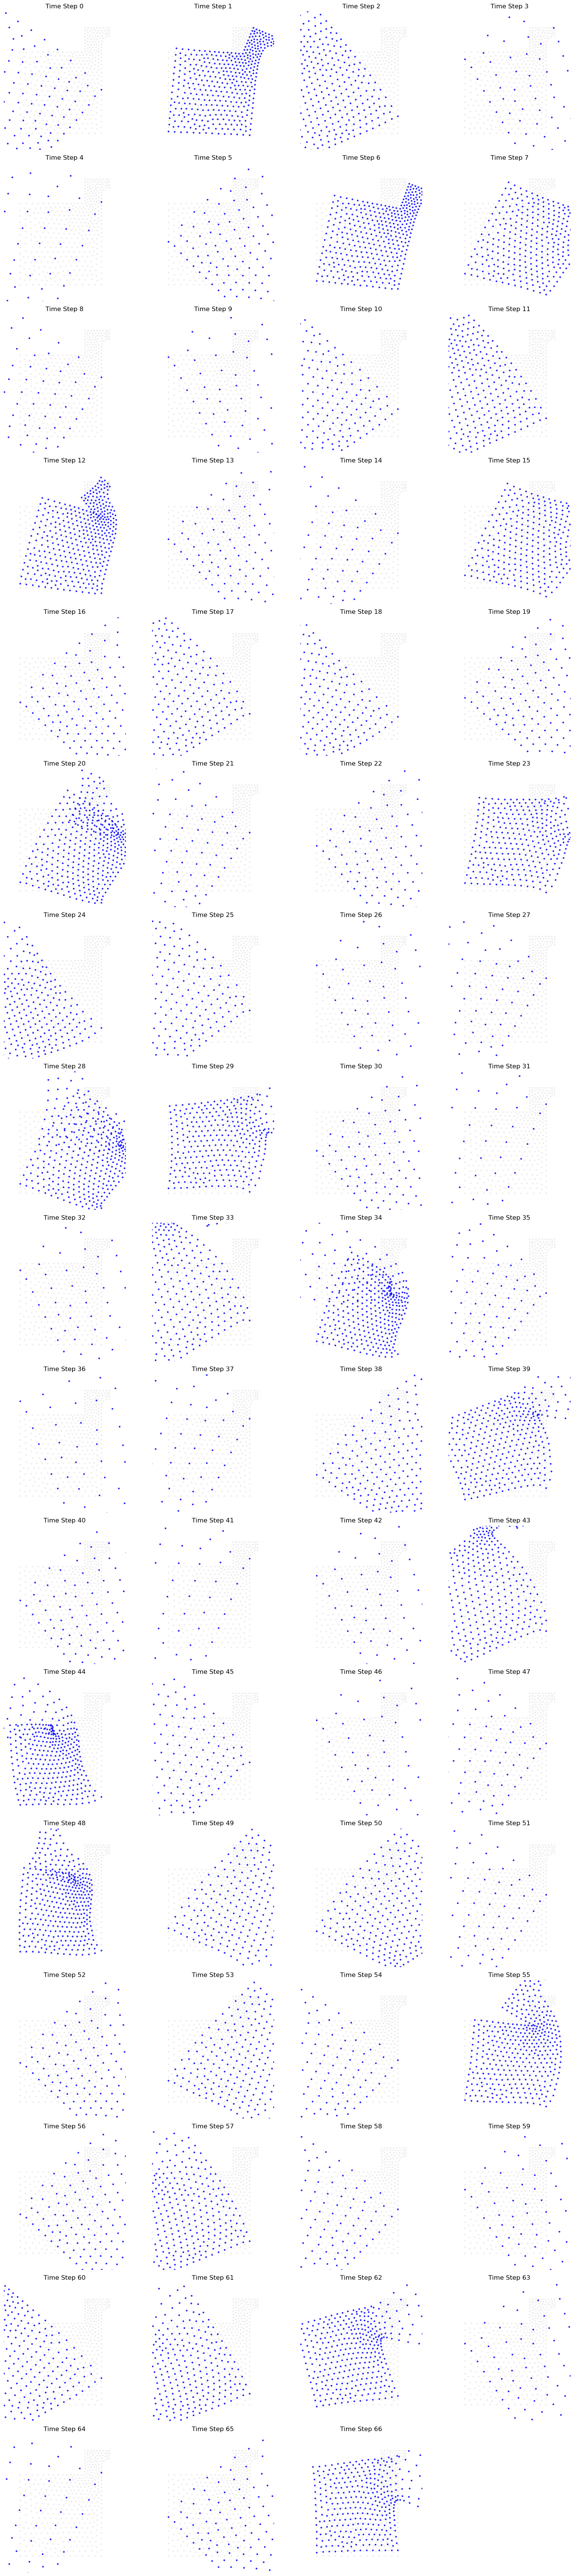

In [33]:
# Set number of subplots (adjust cols/rows to your preference)
num_steps = len(time_steps)
cols = 4
rows = int(np.ceil(num_steps / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
axes = axes.flatten()  # Flatten in case of 2D array

for i in range(num_steps):
    ax = axes[i]

    # Reshape displacement
    u_step = u_hist[i].reshape(points.shape)

    # Deformed shape
    deform = points + u_step

    # Plot original and deformed mesh
    ax.scatter(points[:, 0], points[:, 1], c='gray', s=5, alpha=0.1)
    ax.scatter(deform[:, 0], deform[:, 1], c='blue', s=5, alpha=0.8)

    ax.set_title(f'Time Step {i}')
    ax.set_xlim(points[:, 0].min() - 2, points[:, 0].max() + 2)
    ax.set_ylim(points[:, 1].min() - 2, points[:, 1].max() + 2)
    ax.set_aspect('equal')
    ax.axis('off')

# Hide unused subplots if any
for i in range(num_steps, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


In [34]:
# # Setup plot

# fig, ax = plt.subplots(figsize=(6, 6))
# sc = ax.scatter(points[:, 0], points[:, 1], c='blue', s=10, alpha = 0.1)
# ax.set_xlim(points[:, 0].min() - 2, points[:, 0].max() + 2)
# ax.set_ylim(points[:, 1].min() - 2, points[:, 1].max() + 2)
# ax.set_title("Structure Deformation Over Time")
# ax.set_aspect('equal')

# for i in range(len(time_steps)):
#     deform = points + u_hist[i]
#     ax.scatter(deform[:, 0], deform[:, 1], s=10, alpha=0.2)


# ax.legend()

# plt.show()